## Fake News Detection using Tensorflow (and Logistic Regression with TFIDF)- Rohan Mahajan 08/23

Steps:
1. Importing data and initial preprocessing of data
2. Tokenize, pad and further clean data
3. Word Embedding
4. Create, fit, and test Tensorflow model
5. Visualize reults
6. Train and Test regression model
7. Conclusion

#### 1. Importing data and Initial Pre-Processing of Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/rohanmahajan/Downloads/fake_or_real_news.csv')
df.shape

(6335, 4)

In [4]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
#dropping unecessary columns
df = df.drop(columns = 'title')
df = df.drop(columns = 'Unnamed: 0')
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [6]:
#checking our data for nulls
df.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
df.dropna(subset=['text'], inplace=True)
df.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
#checking text data for duplicates
df['text'].is_unique

False

In [9]:
#duplicate rows
duplicate = df[df.duplicated('text')]
duplicate

,text,label
61,"On this day in 1973, J. Fred Buzhardt, a lawye...",REAL
90,"Killing Obama administration rules, dismantlin...",REAL
157,"Killing Obama administration rules, dismantlin...",REAL
233,"On this day in 1973, J. Fred Buzhardt, a lawye...",REAL
316,"Killing Obama administration rules, dismantlin...",REAL
...,...,...
6227,Email \nISIS barbarians used an industrial dou...,FAKE
6233,Email \nNorth Korea’s Foreign Ministry slammed...,FAKE
6250,A verdict in 2017 could have sweeping conseque...,REAL
6270,"Killing Obama administration rules, dismantlin...",REAL


In [10]:
df = df.drop_duplicates(subset=['text'], keep='first')
df.shape

(6060, 2)

In [11]:
#making sure we removed all duplicates in text column
df['text'].is_unique

True

In [12]:
#label encoding our data in the 'label' column (0 for FAKE, 1 for REAL)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1


In [13]:
#making sure we have a relatively even distribution of fake and real articles 
ones = []
zeroes = []
for e in df['label']:
    if e == 0:
        zeroes.append(e)
    if e == 1:
        ones.append(e)
print(len(zeroes))
print(len(ones))

3071
2989


In [14]:
df

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1
...,...,...
6330,The State Department told the Republican Natio...,1
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",1


#### 2. Tokenizing and further cleaning our data

*Tokenizing is assigning each word within the texts a number so that our texts can be properly input into our model*

In [15]:
#creating a function to clean and tokenize our text
import tensorflow as tf
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index
nltk.download('stopwords')
nltk.download('punkt')

#creating a dictionary to access the numerical values of our stopwords, so we can ultimately remove them from our texts
stop_words = set(stopwords.words('english'))
stop_words_dict = {}
for word in stop_words:
    if word in word_index:
        stop_words_dict[word] = word_index[word]
print(stop_words_dict)


def clean_text(text):
    #removing all stopwords (words like 'a', 'an', 'the', 'my', 'of') and non-letter words from the text
    individual_words = tokenizer.texts_to_sequences([text])[0]
    cleaned_text = []
    for word in individual_words:
        if word not in stop_words_dict.values():
            cleaned_text.append(word)
    return cleaned_text

{'my': 127, 'was': 15, 'any': 102, 'does': 204, 'on': 10, "you've": 5074, 'if': 48, 'i': 33, 'only': 87, 'few': 288, "hadn't": 8449, "doesn't": 941, 'when': 56, 'herself': 1381, 'themselves': 573, 'between': 173, 'more': 41, 'yours': 9894, 'is': 8, 'because': 89, 'not': 22, 'about': 38, "didn't": 838, "it's": 208, 'all': 44, 'some': 75, "she's": 1847, 'theirs': 8067, 'below': 1046, 'he': 14, 'here': 169, "hasn't": 2967, 'did': 137, 'which': 53, 'ourselves': 2081, 'down': 160, 'himself': 478, 'she': 50, 'don': 5275, 'his': 24, 'her': 46, 'for': 9, "shouldn't": 4661, 't': 1031, 'won': 503, 'how': 90, 'as': 11, 'at': 25, "needn't": 66852, 'isn': 87008, 'will': 35, 'be': 17, 'once': 350, 'those': 99, 'out': 54, 'most': 92, "won't": 1717, "isn't": 1411, "you're": 1897, 'll': 31477, 'being': 118, 'while': 111, 'didn': 47398, 'from': 28, "wasn't": 1830, 'o': 3267, 'nor': 1264, 'were': 51, "weren't": 5336, "that'll": 31410, 'into': 80, 'up': 58, 'have': 20, 'this': 18, 'where': 119, 'myself': 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohanmahajan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rohanmahajan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
df

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,U.S. Secretary of State John F. Kerry said Mon...,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,It's primary day in New York and front-runners...,1
...,...,...
6330,The State Department told the Republican Natio...,1
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",1


In [17]:
#running clean_text on our df
df['text'] = df['text'].apply(clean_text)
df

,text,label
0,"[4556, 13404, 26418, 2992, 1272, 625, 491, 57,...",0
1,"[2250, 7977, 16785, 12619, 7072, 16786, 2132, ...",0
2,"[96, 258, 60, 250, 1559, 1528, 26, 461, 467, 8...",1
3,"[62, 52364, 1179, 52365, 329, 526, 139, 4030, ...",0
4,"[282, 158, 57, 247, 484, 8533, 81, 36, 138, 29...",1
...,...,...
6330,"[60, 233, 140, 91, 151, 401, 82, 402, 268, 81,...",1
6331,"[98750, 8447, 726, 98751, 98752, 993, 1626, 10...",0
6332,"[387, 29, 1254, 3114, 3931, 98790, 443, 18206,...",0
6333,"[25235, 30957, 6668, 48404, 84, 9641, 632, 371...",1


In [18]:
#turning our text back into a string using join
def list_to_string(text):
    final_string = ', '.join(str(num) for num in text)
    return final_string

In [19]:
df['text'] = df['text'].apply(list_to_string)
df

,text,label
0,"4556, 13404, 26418, 2992, 1272, 625, 491, 57, ...",0
1,"2250, 7977, 16785, 12619, 7072, 16786, 2132, 1...",0
2,"96, 258, 60, 250, 1559, 1528, 26, 461, 467, 87...",1
3,"62, 52364, 1179, 52365, 329, 526, 139, 4030, 1...",0
4,"282, 158, 57, 247, 484, 8533, 81, 36, 138, 29,...",1
...,...,...
6330,"60, 233, 140, 91, 151, 401, 82, 402, 268, 81, ...",1
6331,"98750, 8447, 726, 98751, 98752, 993, 1626, 108...",0
6332,"387, 29, 1254, 3114, 3931, 98790, 443, 18206, ...",0
6333,"25235, 30957, 6668, 48404, 84, 9641, 632, 371,...",1


In [20]:
#cleaning our sequences
sequences_cleaned= []
for sequence in sequences:
    cleaned_sequence = []
    for num in sequence:
        if num not in stop_words_dict.values():
            cleaned_sequence.append(num)
    sequences_cleaned.append(cleaned_sequence)

In [21]:
#padding our sequences to make them all equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences_cleaned, maxlen=75, padding='post', truncating='post')

In [22]:
padded

array([[ 4556, 13404, 26418, ...,   697,  1083,   153],
       [ 2250,  7977, 16785, ...,    91,   107, 40155],
       [   96,   258,    60, ..., 12621,  1225,    93],
       ...,
       [  387,    29,  1254, ...,   815,  1425,   238],
       [25235, 30957,  6668, ...,  1036,  1288,   429],
       [  862,   194,  2581, ...,  3364,  1025,   236]], dtype=int32)

#### 3. Generating Word Embedding

We need to generate a word embedding in order for our model recognize which words are and are not related to one another. Words in a word embedding are represented in a vector space, with more closely related words closer to each other in said space. Also, we want to express this relationship between words as a number, so we are going to use the glove.6B.50d.txt file which already has many words and their relatedness to other words in terms of floating point numbers.

In [23]:
#parsing through our file and creating a dictionary to represent our word embeddings
word_embeddings = {}
with open('/Users/rohanmahajan/Downloads/glove.6B.50d.txt') as embeddings_file:
    for line in embeddings_file:
        values = line.split()
        word = values[0]
        embedding = []
        for val in values[1:]:
            embedding.append(float(val))
        word_embeddings[word] = embedding
#turning our dictionary into a matrix so it can be inputted into our model
embeddings_matrix = np.zeros((len(word_index)+1, 50))
for word, i in word_index.items():
    embedding_vector = word_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector
embeddings_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
        -0.78581 ],
       [ 0.68047 , -0.039263,  0.30186 , ..., -0.073297, -0.064699,
        -0.26044 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.37878 , -0.59358 ,  0.055043, ..., -0.59179 , -0.10974 ,
        -0.81291 ],
       [ 0.079391, -0.24515 ,  0.053814, ..., -0.11445 ,  0.36078 ,
         0.20451 ]])

#### 4. Creating, fitting, testing Tensorflow model,and testing

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [25]:
#splitting up our data using train_test_split for our Tensorflow model
from sklearn.model_selection import train_test_split
label = []
for value in df['label']:
    label.append(value)
training_sequences, test_sequences, training_labels, test_labels = train_test_split(padded, label, test_size=0.1)

In [36]:
#creating the model
model = tf.keras.Sequential([
    #adding my word embedding matrix to my model
    tf.keras.layers.Embedding(len(word_index)+1, 50,
                              input_length=75, weights=[
                                  embeddings_matrix],
                              trainable=False),
    #converts 40% of neurons to 0s and uses 60% of data to account for it. This is a good way to eliminate the model from basing itself on a certain group of neurons.
    tf.keras.layers.Dropout(0.4),
    #using conv1d to process our data, this is useful because it finds short range patterns within the sequences
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    #same thing as Dropout but for the conv1D layer we just created
    tf.keras.layers.SpatialDropout1D(0.4),
    #looking at every 4 words and taking into account the most important one
    tf.keras.layers.MaxPooling1D(pool_size=4),
    #using LSTM to find long range pattters within the sequencecs
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [37]:
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)
  
history = model.fit(training_sequences, training_labels, 
                    epochs=50,
                    validation_data=(test_sequences,
                                     test_labels), 
                    verbose=2)

Epoch 1/50


2023-08-16 02:13:27.721405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 02:13:27.838089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 02:13:27.924477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 02:13:29.636299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 02:13:29.685251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


171/171 - 3s - loss: 0.6123 - accuracy: 0.6481 - val_loss: 0.4852 - val_accuracy: 0.7789 - 3s/epoch - 15ms/step
Epoch 2/50
171/171 - 1s - loss: 0.4872 - accuracy: 0.7770 - val_loss: 0.4081 - val_accuracy: 0.8135 - 1s/epoch - 8ms/step
Epoch 3/50
171/171 - 1s - loss: 0.4280 - accuracy: 0.8009 - val_loss: 0.4260 - val_accuracy: 0.8036 - 1s/epoch - 8ms/step
Epoch 4/50
171/171 - 1s - loss: 0.3899 - accuracy: 0.8212 - val_loss: 0.3778 - val_accuracy: 0.8251 - 1s/epoch - 8ms/step
Epoch 5/50
171/171 - 1s - loss: 0.3741 - accuracy: 0.8297 - val_loss: 0.3515 - val_accuracy: 0.8399 - 1s/epoch - 8ms/step
Epoch 6/50
171/171 - 1s - loss: 0.3527 - accuracy: 0.8447 - val_loss: 0.3487 - val_accuracy: 0.8416 - 1s/epoch - 8ms/step
Epoch 7/50
171/171 - 1s - loss: 0.3387 - accuracy: 0.8489 - val_loss: 0.3418 - val_accuracy: 0.8350 - 1s/epoch - 8ms/step
Epoch 8/50
171/171 - 1s - loss: 0.3284 - accuracy: 0.8608 - val_loss: 0.3206 - val_accuracy: 0.8482 - 1s/epoch - 8ms/step
Epoch 9/50
171/171 - 1s - loss: 0.

In [34]:
#testing our model
predictions = np.round(model.predict(test_sequences))

19/19 [==============================] - 0s 4ms/step


2023-08-16 02:11:52.833922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-16 02:11:52.869094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


#### Evaluating results

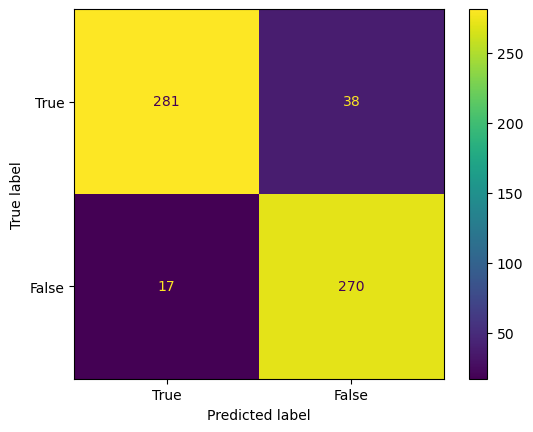

In [866]:
from sklearn import metrics
#visualizing our results through a confusion matrix
confusion_matrix = metrics.confusion_matrix(test_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels = ['True','False'])
cm_display.plot()
plt.show()

In [880]:
accuracy_score_tf = metrics.accuracy_score(test_labels, predictions)
f1_score_tf = metrics.f1_score(test_labels, predictions)
print('accuracy_score =',accuracy_score_tf)
print('f1_score =', f1_score_tf)

accuracy_score = 0.9092409240924092
f1_score = 0.907563025210084


#### 6. Training and testing a logistic regression model using TFIDF on the data

TFIDF determines which words are the most important based on how many times they appear across all texts

In [840]:
#splitting up our data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.1)

In [841]:
#turning our data into a weighted matrix where each row is a text and each column is a unique word in the text and each cell is that [text, word] TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer()
x_tfidf_train = vector.fit_transform(x_train)
x_tfidf_test = vector.transform(x_test)

In [842]:
#performing logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(x_tfidf_train, y_train)

LogisticRegression()

In [872]:
#predicting whether news is real or fake based off model
predicted = log_reg.predict(x_tfidf_test)

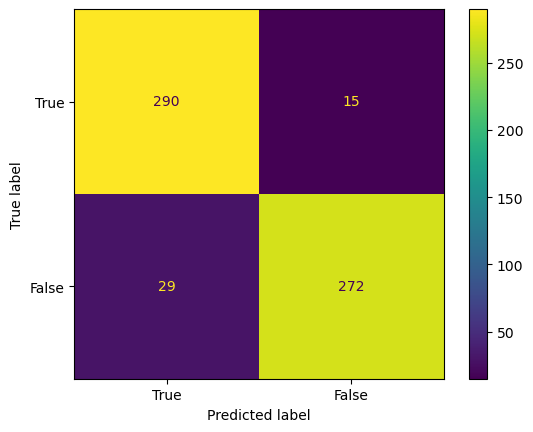

In [871]:
#visualize results using confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, predicted)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['True','False'])
cm.plot()
plt.show()

In [876]:
#accuracy of model
accuracy_score_logreg = metrics.accuracy_score(predicted, y_test)
f1_score_logreg = metrics.f1_score(predicted, y_test)
print('accuracy_score =',accuracy_score_logreg)
print('f1_score =',f1_score_logreg)

accuracy_score = 0.9273927392739274
f1_score = 0.9251700680272109


## 7. Conclusion:

#### As we can see, the logistic regression model slightly outperformed our Tensorflow model in terms of both accuracy and f1 score. In my opinion, they both worked very well and I am pleased with the outcome of this project. 